In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import io

In [2]:
data_o_vib = pd.read_csv("data/Musical training and Pitch perception - O -_ Vib (respuestas) - Respuestas de formulario 1.csv")
data_vib_o = pd.read_csv("data/Musical training and Pitch perception - Vib -_ O - Respuestas de formulario 1.csv")

total_data = pd.concat([data_o_vib, data_vib_o], ignore_index=True)

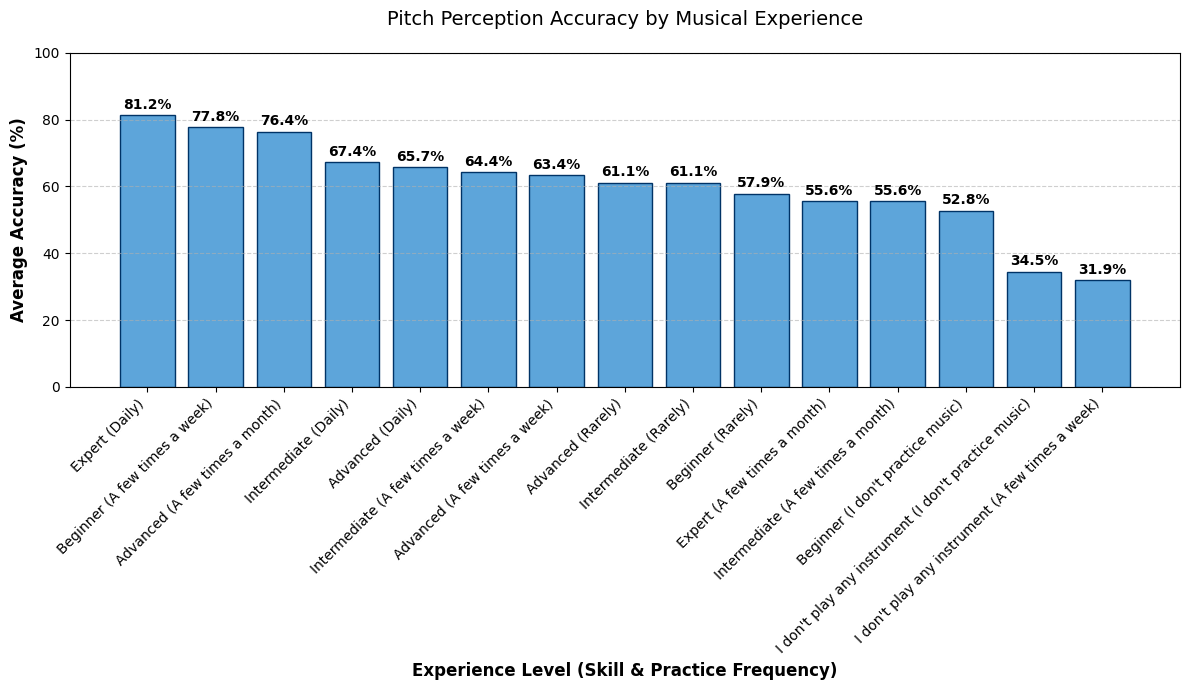

In [3]:
# These represent the pitch change tests (Positive = Ascending, Negative = Descending)
test_cols = [c for c in total_data.columns if c.startswith("(+)") or c.startswith("(-)")]

# 3. Define the accuracy calculation function
def calculate_accuracy(row):
    correct = 0
    total = len(test_cols)
    for col in test_cols:
        # Determine ground truth from the column name
        # Note: Matching the spelling 'Acending' found in the dataset
        expected = "Acending" if col.startswith("(+)") else "Descending"
        if row[col] == expected:
            correct += 1
    return (correct / total) * 100

# Apply accuracy calculation to each participant
total_data['Accuracy'] = total_data.apply(calculate_accuracy, axis=1)

# 4. Create the composite grouping: Skill Level + Practice Frequency
skill_col = "How would you rate your skill on your primary instrument? "
practice_col = "If so, how often do you practice music?"
total_data['Group'] = total_data[skill_col].str.strip() + " (" + total_data[practice_col].str.strip() + ")"

# 5. Aggregate average accuracy by Group
grouped_data = total_data.groupby('Group')['Accuracy'].mean().sort_values(ascending=False).reset_index()

# 6. Plot the results
plt.figure(figsize=(12, 7))
bars = plt.bar(grouped_data['Group'], grouped_data['Accuracy'], color='#5da5da', edgecolor='#003366')

plt.xlabel('Experience Level (Skill & Practice Frequency)', fontsize=12, fontweight='bold')
plt.ylabel('Average Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Pitch Perception Accuracy by Musical Experience', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add percentage labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('accuracy_by_experience.png')
plt.show()

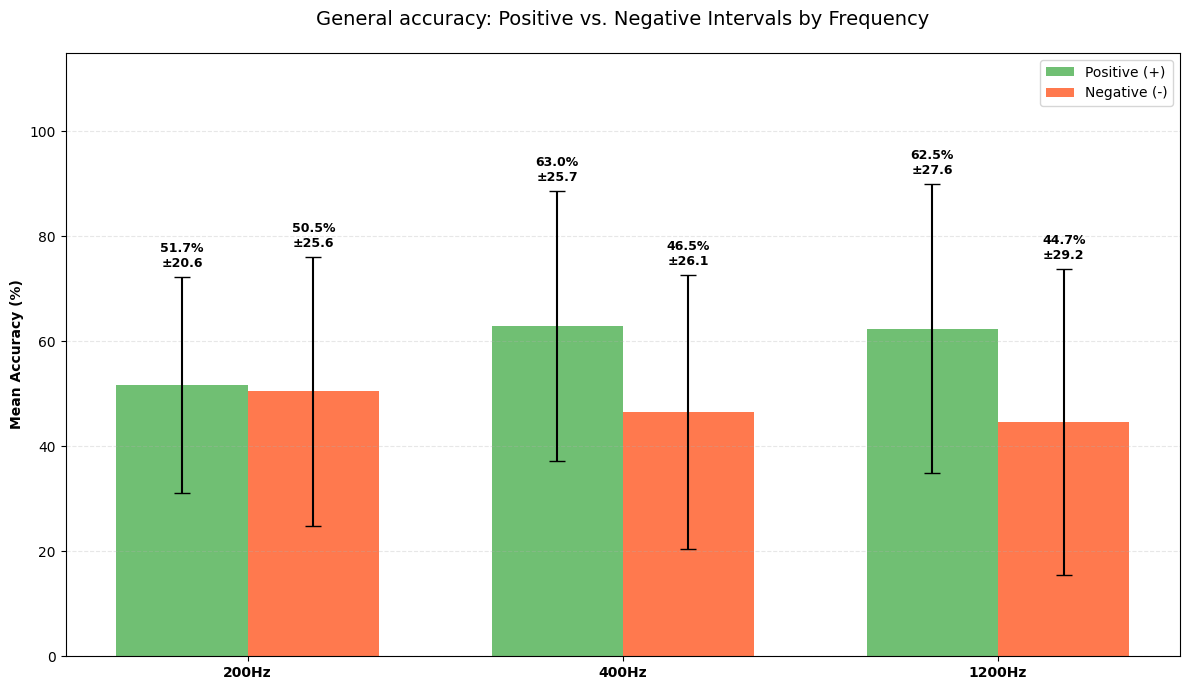

In [4]:
# 1. Prepare Data
# Assuming 'total_data' is your loaded DataFrame from the CSV
test_cols = [c for c in total_data.columns if c.startswith("(+)") or c.startswith("(-)")]
frequencies = ['200', '400', '1200']

def get_acc(row, cols):
    if not cols: return 0
    # Note: Dataset uses 'Acending' (typo included to match your data)
    correct = sum(1 for col in cols if row[col] == ("Acending" if "+" in col else "Descending"))
    return (correct / len(cols)) * 100

results = []
for freq in frequencies:
    for direction, prefix in [('Positive (+)', '(+)'), ('Negative (-)', '(-)')]:
        cols = [c for c in test_cols if f" {freq} " in c and c.startswith(prefix)]
        acc_series = total_data.apply(lambda r: get_acc(r, cols), axis=1)
        results.append({
            'Frequency': f'{freq}Hz',
            'Direction': direction,
            'Accuracy': acc_series.mean(),
            'Std': acc_series.std()
        })

res_total_data = pd.DataFrame(results)

# 2. Plotting
fig, ax = plt.subplots(figsize=(12, 7))
labels = res_total_data['Frequency'].unique()
x = np.arange(len(labels))
width = 0.35

pos_data = res_total_data[res_total_data['Direction'] == 'Positive (+)']
neg_data = res_total_data[res_total_data['Direction'] == 'Negative (-)']

# Create Bars
rects1 = ax.bar(x - width/2, pos_data['Accuracy'], width, yerr=pos_data['Std'], 
                label='Positive (+)', capsize=6, color='#4CAF50', alpha=0.8)
rects2 = ax.bar(x + width/2, neg_data['Accuracy'], width, yerr=neg_data['Std'], 
                label='Negative (-)', capsize=6, color='#FF5722', alpha=0.8)

# Styling
ax.set_ylabel('Mean Accuracy (%)', fontweight='bold')
ax.set_title('General accuracy: Positive vs. Negative Intervals by Frequency', fontsize=14, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontweight='bold')
ax.legend()
ax.set_ylim(0, 115) # Extra space for labels
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Add Labels (%) and Deviation (±)
def add_labels(rects, stds):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        std = stds.iloc[i]
        ax.annotate(f'{height:.1f}%\n±{std:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height + std),
                    xytext=(0, 5), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

add_labels(rects1, pos_data['Std'])
add_labels(rects2, neg_data['Std'])

plt.tight_layout()
plt.show()

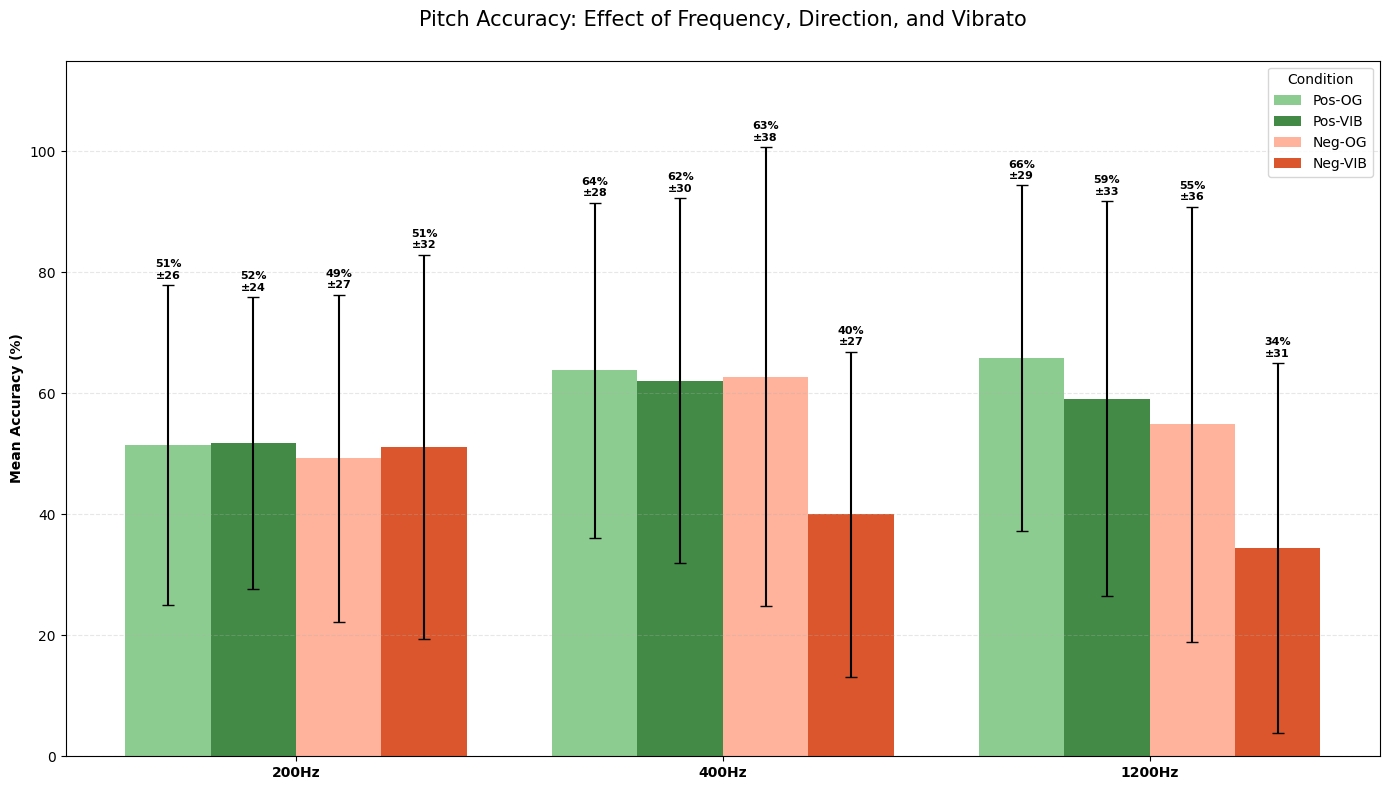

In [5]:
#Identify the test columns (starting with (+) or (-))
# These represent the pitch change tests (Positive = Ascending, Negative = Descending)
# 1. Identify test columns and categories
test_cols = [c for c in total_data.columns if c.startswith("(+)") or c.startswith("(-)")]
frequencies = ['200', '400', '1200']
tone_types = ['og', 'vib']
directions = [('Positive (+)', '(+)'), ('Negative (-)', '(-)')]

def get_acc(row, cols):
    if not cols: return 0
    # Note: Using 'Acending' to match dataset typo
    correct = sum(1 for col in cols if row[col] == ("Acending" if "+" in col else "Descending"))
    return (correct / len(cols)) * 100

# 2. Calculate mean and standard deviation for all 12 combinations
results = []
for freq in frequencies:
    for dir_name, dir_prefix in directions:
        for t_type in tone_types:
            # Filter columns by frequency, sign, and type (og/vib)
            cols = [c for c in test_cols if f" {freq} " in c and c.startswith(dir_prefix) and c.endswith(t_type)]
            acc_series = total_data.apply(lambda r: get_acc(r, cols), axis=1)
            results.append({
                'Freq': f'{freq}Hz', 'Dir': dir_name, 'Tone': t_type,
                'Acc': acc_series.mean(), 'Std': acc_series.std()
            })
res_total_data = pd.DataFrame(results)

# 3. Plotting the Grouped Bar Chart
labels = [f'{f}Hz' for f in frequencies]
x = np.arange(len(labels))
width = 0.2

# Define bar configurations (Direction, Tone, Color, Label)
configs = [
    ('Positive (+)', 'og', '#81C784', 'Pos-OG'),
    ('Positive (+)', 'vib', '#2E7D32', 'Pos-VIB'),
    ('Negative (-)', 'og', '#FFAB91', 'Neg-OG'),
    ('Negative (-)', 'vib', '#D84315', 'Neg-VIB')
]

fig, ax = plt.subplots(figsize=(14, 8))
offsets = [-1.5*width, -0.5*width, 0.5*width, 1.5*width]

for i, (dir_val, tone_val, color_val, label_val) in enumerate(configs):
    subset = res_total_data[(res_total_data['Dir'] == dir_val) & (res_total_data['Tone'] == tone_val)]
    rects = ax.bar(x + offsets[i], subset['Acc'], width, yerr=subset['Std'], 
                   label=label_val, color=color_val, capsize=4, alpha=0.9)
    
    # Add % and Deviation labels on top of bars
    for j, rect in enumerate(rects):
        height = rect.get_height()
        std = subset['Std'].iloc[j]
        ax.annotate(f'{height:.0f}%\n±{std:.0f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height + std),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_ylabel('Mean Accuracy (%)', fontweight='bold')
ax.set_title('Pitch Accuracy: Effect of Frequency, Direction, and Vibrato', fontsize=15, pad=25)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontweight='bold')
ax.legend(title="Condition", bbox_to_anchor=(1, 1))
ax.set_ylim(0, 115)
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

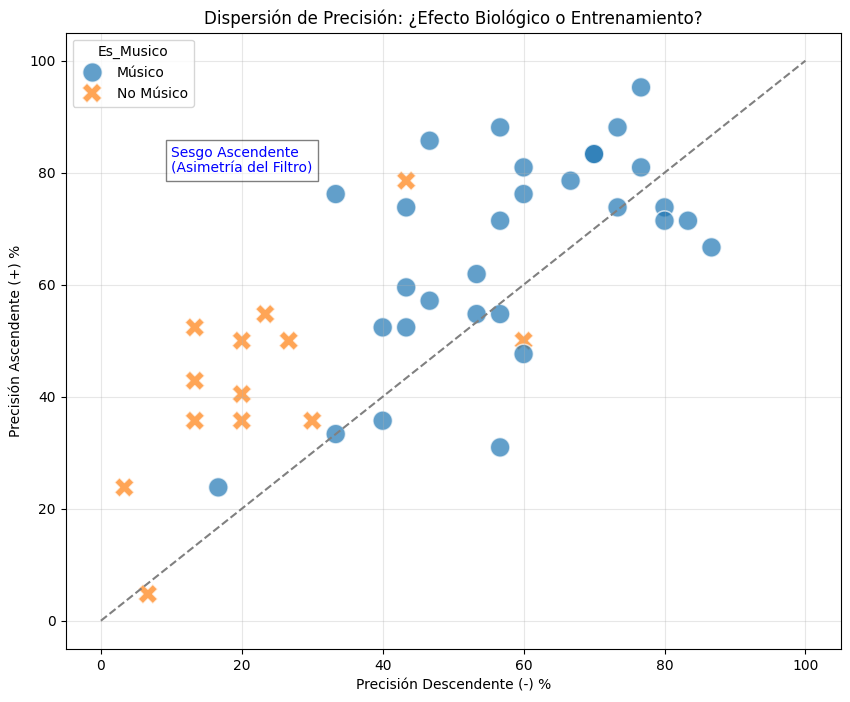

In [8]:
import seaborn as sns

# Calculamos precisión por dirección para cada fila
total_data['Acc_Pos'] = total_data[[c for c in test_cols if c.startswith("(+)")]].apply(lambda r: (r == "Acending").mean() * 100, axis=1)
total_data['Acc_Neg'] = total_data[[c for c in test_cols if c.startswith("(-)")]].apply(lambda r: (r == "Descending").mean() * 100, axis=1)
total_data['Es_Musico'] = total_data['Do you have any musical training (musician, producer, recorder...)? '].apply(lambda x: "Músico" if x != "No" else "No Músico")

# Configuración del gráfico
plt.figure(figsize=(10, 8))
sns.scatterplot(data=total_data, x='Acc_Neg', y='Acc_Pos', hue='Es_Musico', s=200, style='Es_Musico', alpha=0.7)

# Línea de Simetría
plt.plot([0, 100], [0, 100], color='gray', linestyle='--')

plt.title('Dispersión de Precisión: ¿Efecto Biológico o Entrenamiento?')
plt.xlabel('Precisión Descendente (-) %')
plt.ylabel('Precisión Ascendente (+) %')
plt.grid(True, alpha=0.3)

# Identificar la zona de asimetría biológica
plt.text(10, 80, "Sesgo Ascendente\n(Asimetría del Filtro)", color='blue', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

plt.show()